# Data management for module 1

The data contained in this project comes from an experiment conducted in 2015 addressing the question of whether a parasite infection can affect male fertility of wild passerine birds. Data consist of:

 * Experimental data: infected and uninfected individuals
 * Sperm video analyses: Various standard measures obtained from a Computer Assisted Sperm Analyzer (CASA)

This script will first show how the CASA data was obtained using a script that automatically launches ImageJ (Java-based image processing program) and introduces the right parameters to perform the desired video analyses on the ejaculate of birds. From each analysis, a .txt file is created with the data of each spermatozoon detected by the CASA. Then, we will summarize the data contained in each file, and subsequently we will merge those data into a single table. Finally, those data will be matched to a table containing the experimental group of each bird, their social rank, and the time after infection at which the measure was done.

## Automatizing the video analysis in ImageJ with the CASA plug-in

To perform an automated sperm video analysis, the following parameters have to be determined: 1) number of frames to consider a track, 2) the search ratio or number of pixels to consider a single track between frames, 3) the minimum and maximum pixels to consider a spermatozoon head, and 4) the length of the video. These parameters are important determinants of the quality of the analysis. From previous data, we had determined that for the recording conditions and camera quality used to generate the videos, the size of the spermatozoon heads after the threshold of the image is manipulated to remove the tail varies between 34 and 76 pixels (mean ± 2 SE). Additionally, from previous experiments we determined that the optimal video length is 1 second.

To determine the other parameters, we selected 5 videos at random and ran the various combinations of serach ratio and tracked frames yielding to the following results:

<img src="4_sperm_video_optimization/motility_hasli_15_par.jpg" alt="Drawing" style="width: 320px;" align="left"/>
<img src="4_sperm_video_optimization/vcl_hasli_15_par.jpg" alt="Drawing" style="width: 320px;"align="left"/>
<img src="4_sperm_video_optimization/tracks_hasli_15_par.jpg" alt="Drawing" style="width: 320px;" align="right"/>


Using this information, the video analyses were done using a minimum of 16 tracked frames and a search ratio of 13 pixels. The scrip bellow defines a total of 21 parameters for the CASA plug-in. The parameters are the following (for abbreviations see our report or check the [CASA manual](https://imagej.nih.gov/ij/plugins/docs/CASAinstructions.pdf)):

 * a: Minimum number of pixels
 * b: Maximum number of pixels
 * c: Minimum tracked frames
 * d: Maximum speed between frames (a.k.a. search ratio)
 * e: Minimum Velocity Straight Line (VSL) for motile
 * f: Minimum Velocity Average Path (VAP) for motile
 * g: Minimum Velocity Curvilinear (VCL) for motile
 * h: Low VAP speed
 * i: Maximum percentage of path with zero VAP
 * j: Maximum percentage of path with low VAP
 * k: Low VAP speed 2
 * l: Low VCL speed
 * m: High Wobble (WOB)
 * n: High Linearity (LIN)
 * o: High WOB 2
 * p: High LIN 2
 * q: Frame rate
 * r: Microns per 1000 pixels
 * s: Print xy-coordinates of tracked sperm
 * t: Print motion characteristics for all tracked cells
 * u: Print median values for motion characteristics

To have full flexibility on the data yield by the CASA, we conducted a fully unrestricted analaysis where parameters e to l are set to zero. However, high wobble and linearity were restricted based on previous data to 200. Finally, based on the specifications of the microscope and the camera, the video was recorded at 25 frames per second with a total of 729 micros per 1000 pixels (For details see [Rojas et al 2015](https://www.frontiersin.org/articles/10.3389/fevo.2016.00067/full)).

*NOTE:* Be aware that ImageJ has to be installed on the computer where the analsys will be conducted, and additionally CASA has to be manually installed to your ImageJ. You can obtain the CASA plug-in [here](https://imagej.nih.gov/ij/plugins/casa.html). For further information about the plug-in consult [Wilson-Leedy and Ingermann (2006)](https://pubmed.ncbi.nlm.nih.gov/17137620/).

In [ ]:
# RUN THIS C+ CODE AS A MACRO IN IMAGEJ AND MAKE SURE THE DIRECTORY PATHS ARE CORRECT

Folder = getDirectory("Here_your_path"); // Refer here to the directory that contains your sperm videos.

images = getFileList(Folder); // The videos are fully decompressed, so they are treated as consecutive single images


for (i=0; i<images.length; i++) {

   inputPath = Folder + images[i];
 
run("AVI...", "select=inputPath first=51 last=76"); // omits the 50 first frames and goes until the frame 76, which makes a second of analysis
name = getTitle;
txt_name =replace(name, ".avi",".txt");
run("8-bit");
setAutoThreshold("Default dark");
//run("Threshold...");
setThreshold(0, 110); // Modify the image so that only the heads of the sperm cells are visible.
setThreshold(0, 110);
setOption("BlackBackground", false);
run("Convert to Mask", "method=Default background=Dark black"); // Inverts the background and now the sperm cells look like black dot on a white background
run("CASA ", "a,=34.0 b,=76.000000000 c,=16.000000000 d,=13.00000000 e,=0.000 f,=0.000000000 g,=0.000000000 h,=0.00000 i,=0.000000000 j,=0.000000000 k,=0.000000000 l,=0.000000000 m,=200.000000000 n,=200.000000000 o,=200.000000000 p,=200.000000000 q,=25.000000000 r,=729.000000000 s,=0 t,=1");
close();
close();
saveAs("Results", "/Target_Directory/"+txt_name);
run ("Close");

}


setBatchMode(false);


## Summarizing the data obtained from CASA for each video

Each file contains seven columns corresponding to the VCL, VAP, VSL, LIN, WOB, PROG, and BCF of each tracked sperm cell. Each row of the file corresponds to a single spermatozoon, and the last row of the file summarizes the data. The mentioned mesurements correspond to:

<img src="2_images/CASA.jpg" alt="Drawing" style="width: 450px;" align="center"/>

<div align="center"> Figure 1. Illustration of the different measurements assesed by the CASA plug-in in ImageJ. </div>

* VCL: Velocity curvilinear; Point to point velocity (total distance traveled) per second
* VAP: Velocity average path; Point to point velocity on a path constructed using a roaming average
* VSL: Velocity straight line; Velocity measured using the first point and the point reached that is furthest from this origin during the measured time period
* LIN: Linearity (=VSL/VAP), describes path curvature
* ALH: Amplitude of Lateral Head displacement (ALH) corresponds to Wobble (WOB; =VAP/VCL), describes side to side movement of the sperm head
* PROG: Progression; The average distance of the sperm from its origin on the average path during all frames analyzed
* BCF: Beat cross frequency; determined by detecting the frequency at which VCL crosses VAP

From each file, we will count the total number of sperm that was tracked. Then, we will remove sperm cells that have low motility and are considered not alive. Thus, using the difference in sperm count we can calculate the proportion of alive sperm. Then, using the alive sperm set, we can calculate the mean scores for the seven measurements. Additionally, as it can be argued that the fastest sperms within an ejaculate are the main determinant of the fertilizing ability of an ejaculate, we also calculate the mean of the seven measures for the 15%, 10%, and 5% fastest sperms.

In [8]:
# The following code will manage the data obtained from the CASA plug-in. Given that each video results in a single .txt file, we create a for loop to summarize them individually and merge all the data in a single table

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import os

path = '1_CASA_output/' # Define the path where the data is
files = [] # Empty vector to store the files
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file)) # Create a list with all the files in the folder that end in .txt

col_names = ["VCL", "VAP", "VSL", "LIN", "WOB", "PROG", "BCF","VCL15", "VAP15", "VSL15", "LIN15", "WOB15", "PROG15", "BCF15","VCL10", "VAP10", "VSL10", "LIN10", "WOB10", "PROG10", "BCF10","VCL5", "VAP5", "VSL5", "LIN5", "WOB5", "PROG5", "BCF5","MOTILITY", "TRACKS", "VIDEO"]
sum_sperm_quality = pd.DataFrame(columns = col_names) # Create empty table that will gather all the summarized data

# Now, we run a for loop to summarize each file, and subsequently append it to the main table.
for i in range(len(files)):
    
    column_names = ["VCL", "VAP", "VSL", "LIN", "WOB", "PROG", "BCF"] # Columns names for initial table
    
    # Read .txt file skipping last line that contains summary. Use column_names, avoid first lane that is created due to the extra lane on the last line.
    df = pd.read_csv(files[i],
                     header = None,
                     skipfooter=1,
                     engine='python',
                     sep = ' ',
                     usecols = range(1,8),
                     names = column_names)
    
    # Total number of sperm counted in the analysis
    total_sperm = df.count()[1]
    
    # Filter for sperm that is motile. This values are based on previous research. Low motility in a counting chamber is often due to drifting. Finally, table by speed, which later will be used to find the 15% 10% and 5% fastest sperm.
    df_alive = df[(df['VCL']>=20) & (df['VAP']>=15) & (df['VSL']>=10)].sort_values(by = ["VCL",
                                                                                         "VAP",
                                                                                         "VSL"],
                                                                                   ascending = False)
    
    # Total number of motile sperm
    motile_sperm = df_alive.count()[1]
    
    # Take video name
    video = [files[i][14:-5]]
    
    # Calculate the proportion of motile sperm
    motile = [motile_sperm / total_sperm]
    
    # Join the motility and the video name in a dataframe
    motility = pd.DataFrame({'MOTILITY': motile,
                             'TRACKS': total_sperm,
                             'VIDEO': video})
    
    # Get the mean measurements for all the motile sperm and store it in av_motile
    av_motile = pd.DataFrame(df_alive.mean()).transpose()
    
    
    # Get the mean measurements for the fastest 15% motile sperm and append it to av_motile in a single row
    av_motile = pd.concat([av_motile,
                       pd.DataFrame(df_alive[:int(round(motile_sperm*0.15,0))].mean()).transpose().rename(columns = {"VCL":"VCL15",
                                                                                                                     "VAP":"VAP15",
                                                                                                                     "VSL":"VSL15",
                                                                                                                     "LIN":"LIN15",
                                                                                                                     "WOB":"WOB15",
                                                                                                                     "PROG":"PROG15",
                                                                                                                     "BCF":"BCF15"})],
                     axis = 1)
    
    # Get the mean measurements for the fastest 10% motile sperm and append it to av_motile in a single row
    av_motile = pd.concat([av_motile,
                       pd.DataFrame(df_alive[:int(round(motile_sperm*0.10,0))].mean()).transpose().rename(columns = {"VCL":"VCL10",
                                                                                                                     "VAP":"VAP10",
                                                                                                                     "VSL":"VSL10",
                                                                                                                     "LIN":"LIN10",
                                                                                                                     "WOB":"WOB10",
                                                                                                                     "PROG":"PROG10",
                                                                                                                     "BCF":"BCF10"})],
                     axis = 1)

    # Get the mean measurements for the fastest 5% motile sperm and append it to av_motile in a single row
    av_motile = pd.concat([av_motile,
                       pd.DataFrame(df_alive[:int(round(motile_sperm*0.05,0))].mean()).transpose().rename(columns = {"VCL":"VCL5",
                                                                                                                     "VAP":"VAP5",
                                                                                                                     "VSL":"VSL5",
                                                                                                                     "LIN":"LIN5",
                                                                                                                     "WOB":"WOB5",
                                                                                                                     "PROG":"PROG5",
                                                                                                                     "BCF":"BCF5"})],
                     axis = 1)

    
    # Append to av_motile the proportion on motile sperm and the sperm video
    av_motile = pd.concat([av_motile, motility], axis = 1)
    
    # Append the row of summarized data to the main table, and ignore the original index of av_motile (e.g. else all the rows would be called 0)
    sum_sperm_quality = sum_sperm_quality.append(av_motile, ignore_index = True)

sum_sperm_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VCL       319 non-null    float64
 1   VAP       319 non-null    float64
 2   VSL       319 non-null    float64
 3   LIN       319 non-null    float64
 4   WOB       319 non-null    float64
 5   PROG      319 non-null    float64
 6   BCF       319 non-null    float64
 7   VCL15     314 non-null    float64
 8   VAP15     314 non-null    float64
 9   VSL15     314 non-null    float64
 10  LIN15     314 non-null    float64
 11  WOB15     314 non-null    float64
 12  PROG15    314 non-null    float64
 13  BCF15     314 non-null    float64
 14  VCL10     308 non-null    float64
 15  VAP10     308 non-null    float64
 16  VSL10     308 non-null    float64
 17  LIN10     308 non-null    float64
 18  WOB10     308 non-null    float64
 19  PROG10    308 non-null    float64
 20  BCF10     308 non-null    float6

In [9]:
# Run this line to save the data frame generated above. Remove the # before running the line
# sum_sperm_quality.to_csv("3_data/summary_ejaculate_quality.txt", sep = " ", index = False, decimal = ".")

### Vizualization of the summarized data from the ejaculate videos

Bellow we generate first a series of scatter plots and histograms to have a general idea on the potential correlations between the different measurements as well as the distribution of each variable.


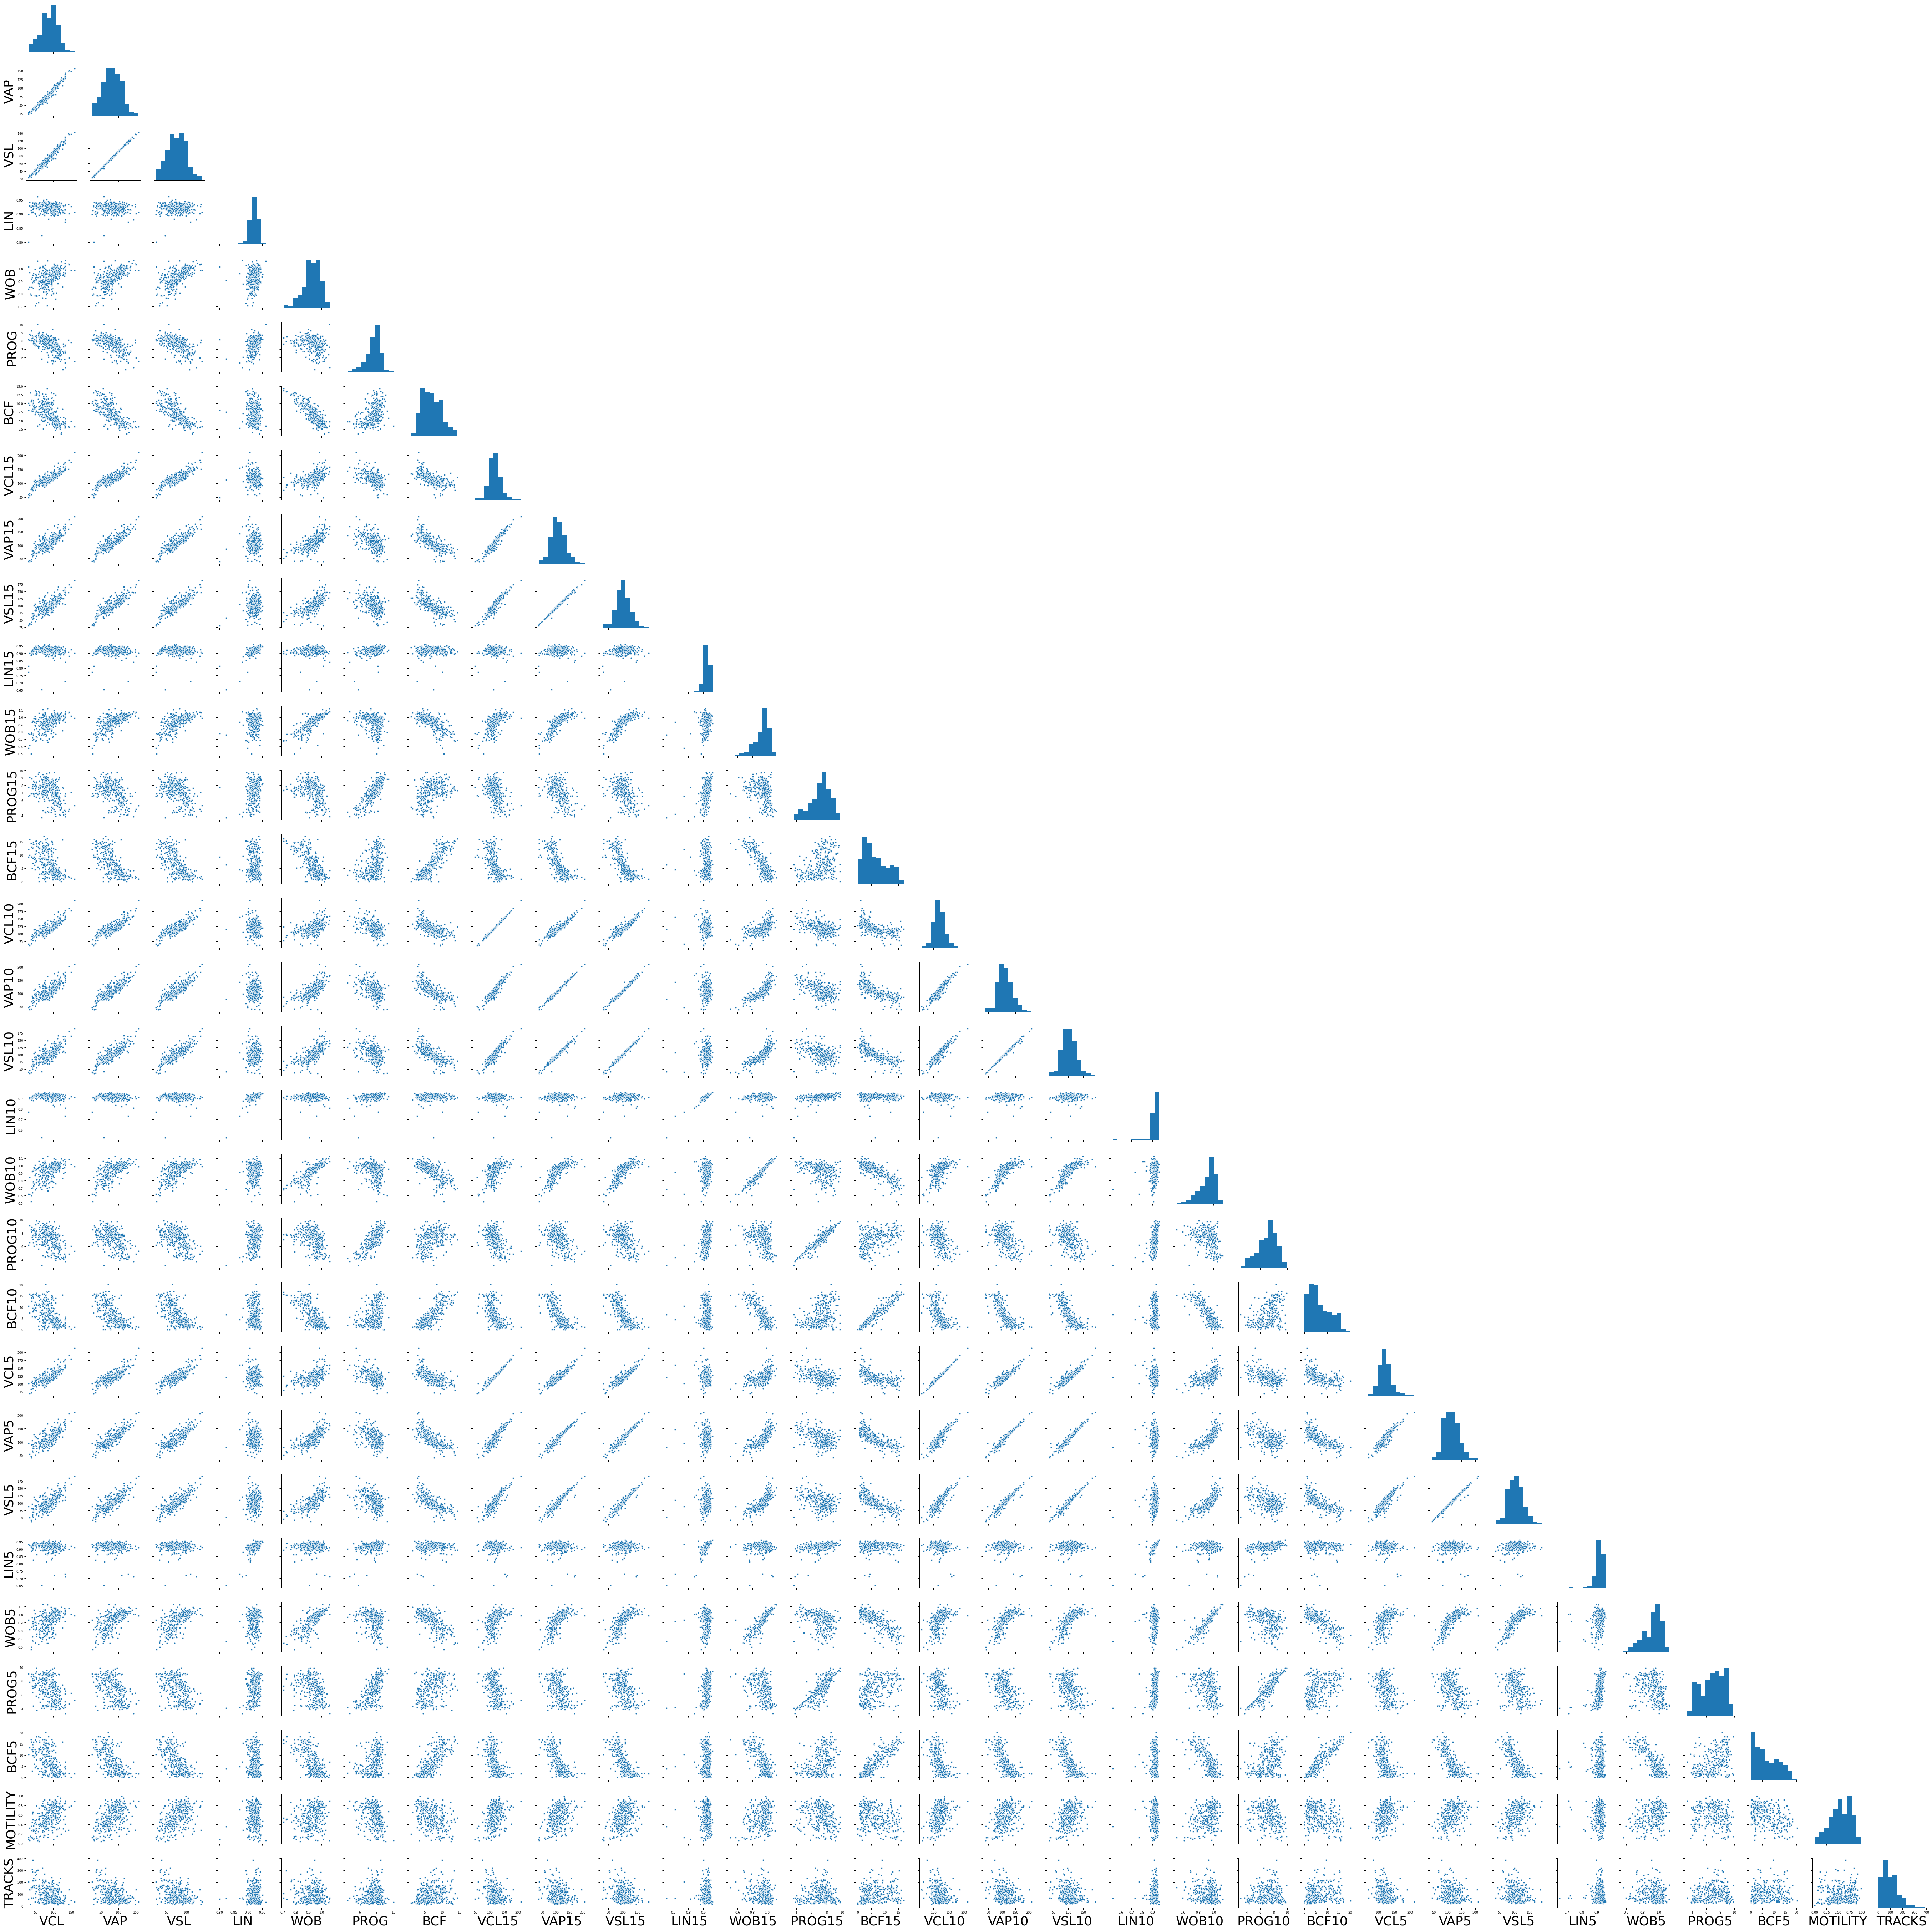

In [2]:
# Visualize the raw data regardless of treatment and collection date.
# The plot will show histograms that will help to understand the distribution of data as well as potential correlations.
#sns.set_context(rc={"axes.labelsize":20})
sns.set_context("paper", rc={"axes.labelsize":36})
plot1 = sns.pairplot(sum_sperm_quality.loc[:,],
                    #kind = "reg",
                    #diag_kind = "hist",
                    corner = True#,
                    #diag_kws = dict(bins = 10)
                    )
plot1.savefig('./2_images/explotatory_scatter.png', transparent = True)

From the above figure it can be observed that:

 * Beat-cross frequency does not seem to be normally distributed (looks like a Poisson diistributed variable)
 * Linearity has very little variation
 * Several measurements of sperm velocity are likely correlated

Given the points noted above, we now calculated a correlation matrix for the above variables and plotted such matrix as a heatmap.

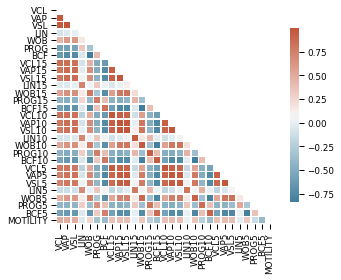

In [22]:
# Visualizing the correlations between ejaculate quality measurements
corr = sum_sperm_quality.corr(method = "pearson")

corr_plot = sns.heatmap(corr,
                        mask = np.triu(np.ones_like(corr, dtype=bool)),
                        xticklabels = corr.columns,
                        yticklabels = corr.columns,
                        square = True,
                        linewidths=.5,
                        cbar_kws={"shrink": .8},
                        cmap = sns.diverging_palette(230,
                                                     20,
                                                     as_cmap=True))
figure = corr_plot.get_figure()
figure.savefig('./2_images/explotatory_corr.png', transparent = True)

### Generating the final table for data analysis

The above script aimed mainly to summarize the data obtained from the CASA plug-in for ImageJ. Consequently, after summarizing the data from each video, we gathered everything together on a single table. Then, we proceeded to visualize those data, noting that the different measures of sperm velocity are correlated to each other.

In this section, we will merge the summary data with the main data from the experiment. Within the main data, we can find the date of collection for each sample, sampling group (the experiment was divided in small experimental groups for feasibility), days after the onset of the experiment, treatment (infected vs uninfected), aviary where the birds were captive, unique ID for each bird, unique within aviary color ring for each bird, time at which the ejaculate was collected, body mass, several measurements of cloacal protuberance, and the file name under which the ejaculate video was saved. Thus, we could use the video name as a common identifier to merge the data from the two tables.

In [25]:
bird_data = pd.read_csv("3_data/bird_datasheet.txt", header = 0, sep = '\t')
bird_data['INFECTION_STAGE'] = bird_data.MANIPULATION_DAY.replace([0,9,18],['Before', "Acute", "Chronic"])
bird_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              336 non-null    object 
 1   SAMPLING_GROUP    336 non-null    int64  
 2   EXP_DAY           336 non-null    int64  
 3   MANIPULATION_DAY  336 non-null    int64  
 4   TREATMENT         336 non-null    object 
 5   AVIARY            336 non-null    int64  
 6   ID                336 non-null    object 
 7   COLOR_RING        336 non-null    object 
 8   SAMPLING_TIME     336 non-null    int64  
 9   BODY_MASS         336 non-null    float64
 10  VIDEO             336 non-null    object 
 11  CLOACA_HIGH1      336 non-null    float64
 12  CLOACA_HIGH2      336 non-null    object 
 13  CLOACA_HIGH3      336 non-null    float64
 14  CLOACA_WIDTH1     336 non-null    float64
 15  CLOACA_WIDTH2     336 non-null    object 
 16  CLOACA_WIDTH3     336 non-null    float64
 1

In [35]:
# Merging experimental data and sperm data
full_df = bird_data.merge(sum_sperm_quality, on = 'VIDEO', how = "outer")
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              336 non-null    object 
 1   SAMPLING_GROUP    336 non-null    int64  
 2   EXP_DAY           336 non-null    int64  
 3   MANIPULATION_DAY  336 non-null    int64  
 4   TREATMENT         336 non-null    object 
 5   AVIARY            336 non-null    int64  
 6   ID                336 non-null    object 
 7   COLOR_RING        336 non-null    object 
 8   SAMPLING_TIME     336 non-null    int64  
 9   BODY_MASS         336 non-null    float64
 10  VIDEO             336 non-null    object 
 11  CLOACA_HIGH1      336 non-null    float64
 12  CLOACA_HIGH2      336 non-null    object 
 13  CLOACA_HIGH3      336 non-null    float64
 14  CLOACA_WIDTH1     336 non-null    float64
 15  CLOACA_WIDTH2     336 non-null    object 
 16  CLOACA_WIDTH3     336 non-null    float64
 1

In [36]:
## Fixing values within the table that had a ',' instead of a '.' as separator and are thus interpreted by Python as type 'object'

full_df['CLOACA_HIGH2'] = full_df['CLOACA_HIGH2'].map(lambda x: x.lstrip('.').rstrip('.')).astype('float64')
full_df['CLOACA_WIDTH2'][full_df['CLOACA_WIDTH2'] == '5,59'] = 5.59
full_df['CLOACA_WIDTH2'][full_df['CLOACA_WIDTH2'] == '5,56'] = 5.56
full_df['CLOACA_WIDTH2'] = full_df['CLOACA_WIDTH2'].astype('float64')
full_df['CLOACA_LENGTH2'][full_df['CLOACA_LENGTH2'] == '5,45'] = 5.45
full_df['CLOACA_LENGTH2'] = full_df['CLOACA_LENGTH2'].astype('float64')
full_df['CLOACA_LENGTH3'][full_df['CLOACA_LENGTH3'] == '5,67'] = 5.67
full_df['CLOACA_LENGTH3'] = full_df['CLOACA_LENGTH3'].astype('float64')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              336 non-null    object 
 1   SAMPLING_GROUP    336 non-null    int64  
 2   EXP_DAY           336 non-null    int64  
 3   MANIPULATION_DAY  336 non-null    int64  
 4   TREATMENT         336 non-null    object 
 5   AVIARY            336 non-null    int64  
 6   ID                336 non-null    object 
 7   COLOR_RING        336 non-null    object 
 8   SAMPLING_TIME     336 non-null    int64  
 9   BODY_MASS         336 non-null    float64
 10  VIDEO             336 non-null    object 
 11  CLOACA_HIGH1      336 non-null    float64
 12  CLOACA_HIGH2      336 non-null    float64
 13  CLOACA_HIGH3      336 non-null    float64
 14  CLOACA_WIDTH1     336 non-null    float64
 15  CLOACA_WIDTH2     336 non-null    float64
 16  CLOACA_WIDTH3     336 non-null    float64
 1

<ipython-input-36-c987035c4960>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['CLOACA_WIDTH2'][full_df['CLOACA_WIDTH2'] == '5,59'] = 5.59
<ipython-input-36-c987035c4960>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['CLOACA_WIDTH2'][full_df['CLOACA_WIDTH2'] == '5,56'] = 5.56
<ipython-input-36-c987035c4960>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['CLOACA_LENGTH2'][full_df['CLOACA_LENGTH2'] == '5,45

# Data analysis and visualization of results for module 2

Now we can use the clean dataset that was generated in the data management section to test our main question: Do parasites affect male fertility in a common bird? More specifically, we can test our prediction that males infected by a parasite will produce ejaculates of lower quality.

In order to do so, we will first summarize the various variables that are correlated into a single principal component. For this, we will use VCL, VAP, VSL, LIN, WOB, PROG, and BCF, as they describe the swimming ability of sperm (i.e. how fast, straight, and efficient sperm within an ejaculate swimms). We will then calculate the cloacal volume using the cloaca height, width, and length using the following formula:

$Volume = \pi  (\frac{Depth}{2} \frac{Height}{2}) Length$

Cloacal protuberance volume is used as a proxy of total semen production, with larger cloacas storing bigger amounts of semen.

Altogether, we analyse separately six different measures of ejaculate quality: Proportion of alive sperm, sperm swimming ability (principal component) for all, 15%, 10%, and 5% fastest sperm, and cloacal protuberance volume. Each model will include treatment, time, and their interaction as explanatory variables. Importantly, time in this experiment relates to different infection stages, namely before infection, accute infection, and chronic infection. Consequently, time is treated as a categorical variable. Additionally, given that three measurements were taken for each individual, we use the identity of the individual as a random slope.


In [7]:
full_df["cloaca_depth"] = (full_df.CLOACA_WIDTH1 + full_df.CLOACA_WIDTH2 + full_df.CLOACA_WIDTH3) / 3
full_df["cloaca_height"] = (full_df.CLOACA_HIGH1 + full_df.CLOACA_HIGH2 + full_df.CLOACA_HIGH3) / 3
full_df["cloaca_length"] = (full_df.CLOACA_LENGTH1 + full_df.CLOACA_LENGTH2 + full_df.CLOACA_LENGTH3) / 3
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              336 non-null    object 
 1   SAMPLING_GROUP    336 non-null    int64  
 2   EXP_DAY           336 non-null    int64  
 3   MANIPULATION_DAY  336 non-null    int64  
 4   TREATMENT         336 non-null    object 
 5   AVIARY            336 non-null    int64  
 6   ID                336 non-null    object 
 7   COLOR_RING        336 non-null    object 
 8   SAMPLING_TIME     336 non-null    int64  
 9   BODY_MASS         336 non-null    float64
 10  VIDEO             336 non-null    object 
 11  CLOACA_HIGH1      336 non-null    float64
 12  CLOACA_HIGH2      336 non-null    float64
 13  CLOACA_HIGH3      336 non-null    float64
 14  CLOACA_WIDTH1     336 non-null    float64
 15  CLOACA_WIDTH2     336 non-null    float64
 16  CLOACA_WIDTH3     336 non-null    float64
 1

In [8]:
import math
full_df['Cloacal_Protuberance'] = math.pi * (full_df.cloaca_depth/2) * (full_df.cloaca_height/2) * full_df.cloaca_length


In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Fixed columns for subsets
fixed_cols = ['SAMPLING_GROUP',
              'MANIPULATION_DAY',
              'TREATMENT',
              'AVIARY',
              'ID',
              'COLOR_RING',
              'SAMPLING_TIME',
              'BODY_MASS',
              'INFECTION_STAGE']


# PCA for all motile sperm

## Remove rows with NaN
responses = ["VCL", "VAP", "VSL", "LIN", "WOB", "PROG", "BCF"]
cols = fixed_cols + responses

df100 = full_df.dropna(axis = 0, subset = ["VCL"]).loc[:,cols].copy().reset_index()

## Scale and center data
x = df100.loc[:, responses].values
x = StandardScaler().fit_transform(x) # normalizing the features

## PCA
pca_swimm = PCA(n_components = 2)
pca100 = pca_swimm.fit_transform(x)
swimming_ability = pd.DataFrame(data = pca100
                                , columns = ['PC1', 'PC2'])
print('Explained variation per principal component: {}'.format(pca_swimm.explained_variance_ratio_))
print('Rotations in PC1 are: {}'.format(pca_swimm.components_[0]))

## Merge table
df100 = pd.concat([df100, swimming_ability], axis = 1)




# PCA for 15% fastest sperm

## Remove rows with NaN
responses = ["VCL15", "VAP15", "VSL15", "LIN15", "WOB15", "PROG15", "BCF15"]
cols = fixed_cols + responses

df15 = full_df.dropna(axis = 0, subset = ["VCL15"]).loc[:,cols].copy().reset_index()

## Scale and center data
x15 = df15.loc[:, responses].values
x15 = StandardScaler().fit_transform(x15) # normalizing the features

## PCA
pca_swimm = PCA(n_components = 2)
pca15 = pca_swimm.fit_transform(x15)
swimming_ability = pd.DataFrame(data = pca15
                                , columns = ['PC1', 'PC2'])
print('Explained variation per principal component: {}'.format(pca_swimm.explained_variance_ratio_))
print('Rotations in PC1 are: {}'.format(pca_swimm.components_[0]))

## Merge table
df15 = pd.concat([df15, swimming_ability], axis = 1)







# PCA for 10% fastest sperm

## Remove rows with NaN
responses = ["VCL10", "VAP10", "VSL10", "LIN10", "WOB10", "PROG10", "BCF10"]
cols = fixed_cols + responses

df10 = full_df.dropna(axis = 0, subset = ["VCL10"]).loc[:,cols].copy().reset_index()

## Scale and center data
x10 = df10.loc[:, responses].values
x10 = StandardScaler().fit_transform(x10) # normalizing the features

## PCA
pca_swimm = PCA(n_components = 2)
pca10 = pca_swimm.fit_transform(x10)
swimming_ability = pd.DataFrame(data = pca10
                                , columns = ['PC1', 'PC2'])
print('Explained variation per principal component: {}'.format(pca_swimm.explained_variance_ratio_))
print('Rotations in PC1 are: {}'.format(pca_swimm.components_[0]))

## Merge table
df10 = pd.concat([df10, swimming_ability], axis = 1)



# PCA for 5% fastest sperm

## Remove rows with NaN
responses = ["VCL5", "VAP5", "VSL5", "LIN5", "WOB5", "PROG5", "BCF5"]
cols = fixed_cols + responses

df5 = full_df.dropna(axis = 0, subset = ["VCL5"]).loc[:,cols].copy().reset_index()

## Scale and center data
x5 = df5.loc[:, responses].values
x5 = StandardScaler().fit_transform(x5) # normalizing the features

## PCA
pca_swimm = PCA(n_components = 2)
pca5 = pca_swimm.fit_transform(x5)
swimming_ability = pd.DataFrame(data = pca5
                                , columns = ['PC1', 'PC2'])
print('Explained variation per principal component: {}'.format(pca_swimm.explained_variance_ratio_))
print('Rotations in PC1 are: {}'.format(pca_swimm.components_[0]))

## Merge table
df5 = pd.concat([df5, swimming_ability], axis = 1)

Explained variation per principal component: [0.62910799 0.18621664]
Rotations in PC1 are: [ 0.43660889  0.46313954  0.46213542 -0.02556627  0.34918019 -0.31124778
 -0.40230544]
Explained variation per principal component: [0.63919657 0.20116429]
Rotations in PC1 are: [ 0.41933567  0.46406843  0.46135829  0.00928749  0.40898139 -0.26056124
 -0.40087707]
Explained variation per principal component: [0.63723272 0.20211949]
Rotations in PC1 are: [ 0.41463682  0.46467784  0.46017938 -0.01197542  0.40894101 -0.27307742
 -0.3980431 ]
Explained variation per principal component: [0.62786106 0.21311859]
Rotations in PC1 are: [ 0.41492952  0.46894604  0.46201337 -0.04165741  0.40738927 -0.25323697
 -0.40328206]


## Statistical analyses

In this section we are going to perform two analyses. First, we are going to assess the repeatability (also known as intraclass correlation) from the measurements of cloacal protuberance, as a mean of quality of data assessment. To do so, we will build a mixed effect linear model with just the intercept and using the identity of the individual measurement as random effect. Then, we will performed for each of the six measurements of ejaculate quality to test whether the parasite infection significantly affects ejaculate quality. Thus, each model will use the ejaculate quality measure as a response variable, and we will include treatment, infection stage, and their interaction as fixed effects. Further, each model will include the identity of each male as well as the aviary as random effects.

In [10]:
# Packages needed for the upcoming analyses
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as plt
import scipy.stats as stats
import matplotlib.pyplot as plt2

### Repeatability for cloaca measurements

In [11]:
# Repeatability cloaca height

# First, convert table to a long table
long_ch = pd.wide_to_long(full_df[['VIDEO', 'CLOACA_HIGH1', 'CLOACA_HIGH2', 'CLOACA_HIGH3']],
                          stubnames = 'CLOACA_HIGH',
                          i = 'VIDEO',
                          j = 'MEASURE').reset_index(level = ['VIDEO', 'MEASURE'])

rep_ch = smf.mixedlm("CLOACA_HIGH ~ 1",
                     long_ch,
                     groups = long_ch['VIDEO'])
rep_ch_fit = rep_ch.fit()
print(rep_ch_fit.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CLOACA_HIGH
No. Observations: 1008    Method:             REML       
No. Groups:       336     Scale:              0.0627     
Min. group size:  3       Log-Likelihood:     -480.3154  
Max. group size:  3       Converged:          Yes        
Mean group size:  3.0                                    
----------------------------------------------------------
           Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  4.795     0.030  162.432  0.000   4.737   4.853
Group Var  0.272     0.111                                



In [12]:
# Repeatability cloaca width

# First, convert table to a long table
long_cw = pd.wide_to_long(full_df[['VIDEO', 'CLOACA_WIDTH1', 'CLOACA_WIDTH2', 'CLOACA_WIDTH3']],
                          stubnames = 'CLOACA_WIDTH',
                          i = 'VIDEO',
                          j = 'MEASURE').reset_index(level = ['VIDEO', 'MEASURE'])

rep_cw = smf.mixedlm("CLOACA_WIDTH ~ 1",
                     long_cw,
                     groups = long_cw['VIDEO'])
rep_cw_fit = rep_cw.fit()
print(rep_cw_fit.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CLOACA_WIDTH
No. Observations: 1008    Method:             REML        
No. Groups:       336     Scale:              0.0741      
Min. group size:  3       Log-Likelihood:     -660.7730   
Max. group size:  3       Converged:          Yes         
Mean group size:  3.0                                     
-----------------------------------------------------------
            Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   6.942     0.043  162.147  0.000   6.858   7.026
Group Var   0.591     0.214                                



In [13]:
# Repeatability cloaca length

# First, convert table to a long table
long_cl= pd.wide_to_long(full_df[['VIDEO', 'CLOACA_LENGTH1', 'CLOACA_LENGTH2', 'CLOACA_LENGTH3']],
                          stubnames = 'CLOACA_LENGTH',
                          i = 'VIDEO',
                          j = 'MEASURE').reset_index(level = ['VIDEO', 'MEASURE'])

rep_cl = smf.mixedlm("CLOACA_LENGTH ~ 1",
                     long_cl,
                     groups = long_cl['VIDEO'])
rep_cl_fit = rep_cl.fit()
print(rep_cl_fit.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CLOACA_LENGTH
No. Observations: 1008    Method:             REML         
No. Groups:       336     Scale:              0.0649       
Min. group size:  3       Log-Likelihood:     -528.8730    
Max. group size:  3       Converged:          Yes          
Mean group size:  3.0                                      
------------------------------------------------------------
             Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    4.945     0.033  149.855  0.000   4.880   5.009
Group Var    0.344     0.136                                



In [14]:
R_ch = 0.272 / (0.272+0.0627)
print('The repeatability of the cloaca height measurements is r = {:.2f}'.format(R_ch))
R_cw = 0.591 / (0.591+0.0741)
print('The repeatability of the cloaca width measurements is r = {:.2f}'.format(R_cw))
R_cw = 0.344 / (0.344+0.0649)
print('The repeatability of the cloaca length measurements is r = {:.2f}'.format(R_cw))

The repeatability of the cloaca height measurements is r = 0.81
The repeatability of the cloaca width measurements is r = 0.89
The repeatability of the cloaca length measurements is r = 0.84


Thus, we can conclude that the measurements are highly repeatable, as for all cases r > 0.8. This assures the quality of the data taken during the experiment.

### Linear mixed models for each of the six measurements of ejaculate quality

#### Swimming ability for all motile sperm

                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               PC1      
No. Observations:                 319                   Method:                           REML     
No. Groups:                       55                    Scale:                            1.5668   
Min. group size:                  3                     Log-Likelihood:                   -569.5957
Max. group size:                  6                     Converged:                        Yes      
Mean group size:                  5.8                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

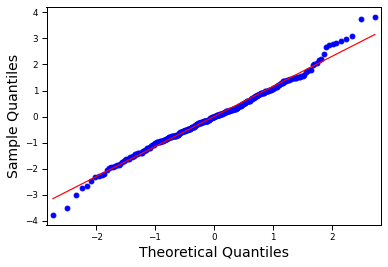

In [72]:
# Model for swimming ability of all motile sperm
mod_swimm100 = smf.mixedlm("PC1 ~ C(INFECTION_STAGE) * C(TREATMENT)",
                     df100,
                     groups = df100['ID'])
mod_swimm100_fit = mod_swimm100.fit()

# Residual QQ plot
sm.qqplot(mod_swimm100_fit.resid, dist = stats.norm, line = 's') ## Do not know why it duplicates the plot

# Summary
print(mod_swimm100_fit.summary())

# Analysis of deviance
print('Wald test')
print(mod_swimm100_fit.wald_test_terms())

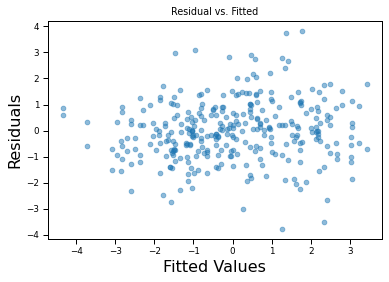

In [36]:
# Residual vs Fitted
plt2.scatter(df100['PC1'] - mod_swimm100_fit.resid, mod_swimm100_fit.resid, alpha = 0.5)
plt2.title("Residual vs. Fitted")
plt2.xlabel("Fitted Values")
plt2.ylabel("Residuals")
plt2.show()

#### Swimming ability for the 15% fastest sperm

                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               PC1      
No. Observations:                 314                   Method:                           REML     
No. Groups:                       55                    Scale:                            2.0754   
Min. group size:                  2                     Log-Likelihood:                   -591.9421
Max. group size:                  6                     Converged:                        Yes      
Mean group size:                  5.7                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

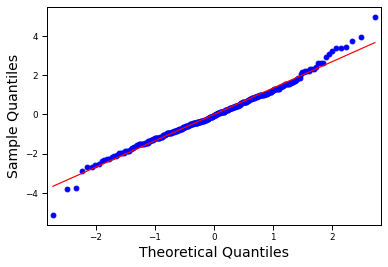

In [73]:
# Model for swimming ability of 15% fastest sperm

mod_swimm15 = smf.mixedlm("PC1 ~ C(INFECTION_STAGE) * C(TREATMENT)",
                     df15,
                     groups = df15["ID"])
mod_swimm15_fit = mod_swimm15.fit()

# Residual plot QQ
sm.qqplot(mod_swimm15_fit.resid, dist = stats.norm, line = 's')

# Summary
print(mod_swimm15_fit.summary())

# Analysis of deviance
print('Wald test')
print(mod_swimm15_fit.wald_test_terms())

In [38]:
# Residual vs Fitted
plt2.scatter(df15['PC1'] - mod_swimm15_fit.resid, mod_swimm15_fit.resid, alpha = 0.5)
plt2.title("Residual vs. Fitted")
plt2.xlabel("Fitted Values")
plt2.ylabel("Residuals")
plt2.show()

#### Swimming ability of the 10% fastest sperm

                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               PC1      
No. Observations:                 308                   Method:                           REML     
No. Groups:                       55                    Scale:                            2.0881   
Min. group size:                  2                     Log-Likelihood:                   -582.7071
Max. group size:                  6                     Converged:                        Yes      
Mean group size:                  5.6                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

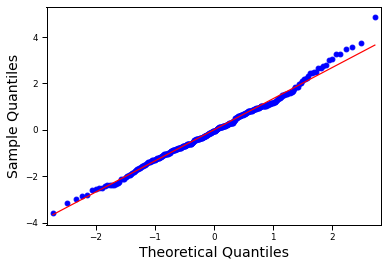

In [75]:
# Model for swimming ability of 10% fastest sperm

mod_swimm10 = smf.mixedlm("PC1 ~ C(INFECTION_STAGE) * C(TREATMENT)",
                     df10,
                     groups = df10["ID"])
mod_swimm10_fit = mod_swimm10.fit()

# Residual plot
sm.qqplot(mod_swimm10_fit.resid, dist = stats.norm, line = 's')

# Summary
print(mod_swimm10_fit.summary())

#Analysis of deviance
print('Wald test')
print(mod_swimm10_fit.wald_test_terms())

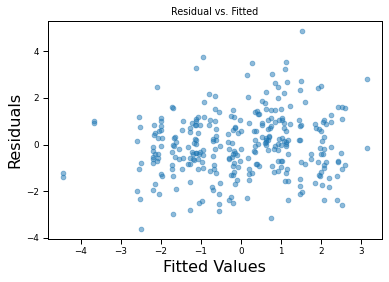

In [40]:
# Residual vs Fitted
plt2.scatter(df10['PC1'] - mod_swimm10_fit.resid, mod_swimm10_fit.resid, alpha = 0.5)
plt2.title("Residual vs. Fitted")
plt2.xlabel("Fitted Values")
plt2.ylabel("Residuals")
plt2.show()

#### Swmming ability for the 5% fastest sperm

                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               PC1      
No. Observations:                 296                   Method:                           REML     
No. Groups:                       55                    Scale:                            2.1863   
Min. group size:                  2                     Log-Likelihood:                   -564.7263
Max. group size:                  6                     Converged:                        Yes      
Mean group size:                  5.4                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

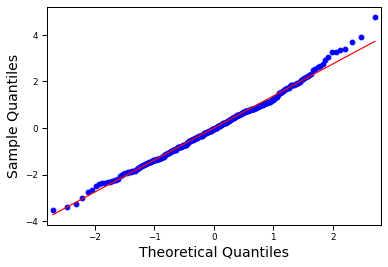

In [77]:
# Model for swimming ability of 5% fastest sperm

mod_swimm5 = smf.mixedlm("PC1 ~ C(INFECTION_STAGE) * C(TREATMENT)",
                     df5,
                     groups = df5["ID"])
mod_swimm5_fit = mod_swimm5.fit()

# Residual plot
sm.qqplot(mod_swimm5_fit.resid, dist = stats.norm, line = 's')

# Summary
print(mod_swimm5_fit.summary())

# Analysis of deviance
print('Wald test')
print(mod_swimm5_fit.wald_test_terms())

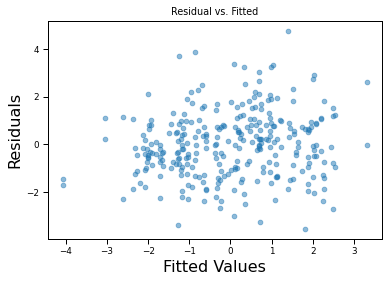

In [44]:
# Residual vs Fitted
plt2.scatter(df5['PC1'] - mod_swimm5_fit.resid, mod_swimm5_fit.resid, alpha = 0.5)
plt2.title("Residual vs. Fitted")
plt2.xlabel("Fitted Values")
plt2.ylabel("Residuals")
plt2.show()

#### Cloaca protuberance

In [64]:
# Boxplot for swimming ability of 10% fastest sperm
sns.set_context("paper", rc={"axes.labelsize":16})
plot3=sns.boxplot(x="INFECTION_STAGE", y="PC1",
            hue="TREATMENT", palette=["dodgerblue", "crimson"],
            data=df10)
plot3.set(xlabel='Infection Stage', ylabel='Swimming ability 10% fastest')
plot3.legend(frameon = False, ncol =2)
sns.despine(offset=25, trim=True)

In [65]:
# Boxplot for swimming ability of 5% fastest sperm
sns.set_context("paper", rc={"axes.labelsize":16})
plot4=sns.boxplot(x="INFECTION_STAGE", y="PC1",
            hue="TREATMENT", palette=["dodgerblue", "crimson"],
            data=df5)
plot4.set(xlabel='Infection Stage', ylabel='Swimming ability 5% fastest')
plot4.legend(frameon = False, ncol =2)
sns.despine(offset=25, trim=True)

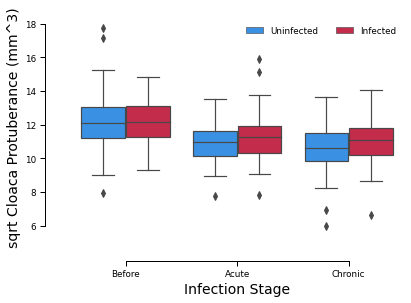

In [61]:
# Boxplot of cloaca protuberance
sns.set_context("paper", rc={"axes.labelsize":14})
plot5=sns.boxplot(x="INFECTION_STAGE", y="SQRT_CP",
            hue="TREATMENT", palette=["dodgerblue", "crimson"],
            data=full_df)
plot5.set(xlabel='Infection Stage', ylabel='sqrt Cloaca Protuberance (mm^3)')
plot5.legend(frameon = False, ncol =2)
sns.despine(offset=25, trim=True)

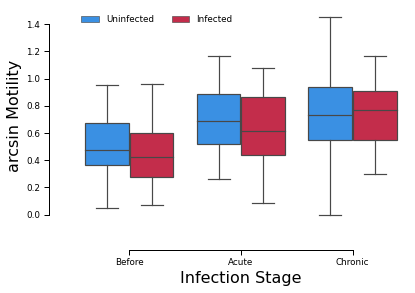

In [67]:
# Boxplot of proportion of motile sperm
sns.set_context("paper", rc={"axes.labelsize":16})
plot6=sns.boxplot(x="INFECTION_STAGE", y="ASIN_MOTILITY",
            hue="TREATMENT", palette=["dodgerblue", "crimson"],
            data=full_df)
plot6.set(xlabel='Infection Stage', ylabel='arcsin Motility')
plot6.legend(frameon = False, ncol =2)
sns.despine(offset=25, trim=True)

## Conclusions

In general, we found that the parasite infection did not affect any of the measures of sperm quality. However, as the experiment progressed, all individuals increased their ejaculate swimming ability and motility. Further, sperm production was slighty decrease with time, as evidenced by the smaller cloacal protuberances.